## Kunskapskontroll 2

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [ ]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
print(mnist.DESCR)


X = mnist["data"]
y = mnist["target"].astype(int)


En enkel kontroll av datasetets dimensioner och eventuella nullvärden genomfördes för att säkerställa datakvalitet.

In [50]:
print (X.shape,y.shape)

(70000, 784) (70000,)


In [ ]:
df = pd.DataFrame(X)
df["target"] = y


In [52]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
780       0
781       0
782       0
783       0
target    0
Length: 785, dtype: int64

Datan delades upp i tre delar med hjälp av train_test_split:

-70 % träningsdata

-15 % valideringsdata

-15 % testdata

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.1765,
    random_state=42,
    stratify=y_trainval
)


Vi vill se dimensionerna på varje dataset.

In [54]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (48998, 784)
Validation: (10502, 784)
Test: (10500, 784)


Visualisera  data

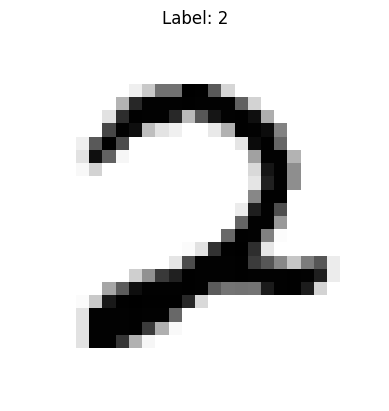

In [55]:
plt.imshow(X_train[0].reshape(28, 28), cmap="binary")
plt.title(f"Label: {y_train[0]}")
plt.axis("off")
plt.show()


Enkel EDA. Funktion för att visa exempel 


In [56]:

def plot_image(X, y, digit, n=16, image_shape=(28, 28)):
    idx = np.where(y == digit)[0][:n]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))

    for ax, i in zip(axes.ravel(), idx):
        img = X[i].reshape(image_shape) if X[i].ndim == 1 else X[i]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.suptitle(f"Examples of digit {digit}")
    plt.tight_layout()
    plt.show()

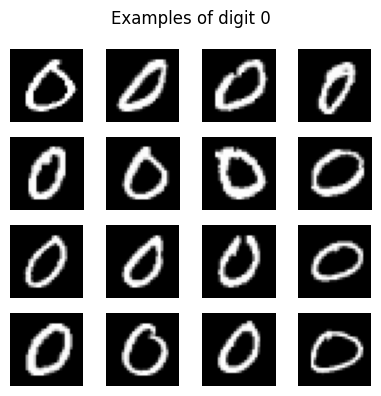

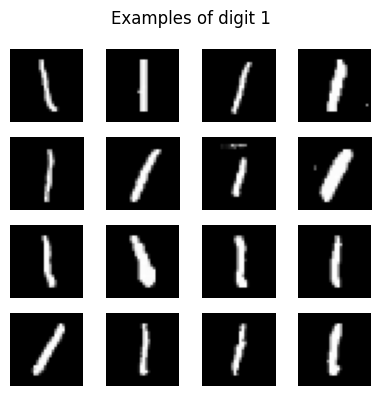

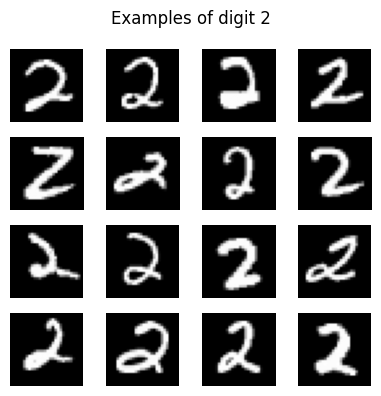

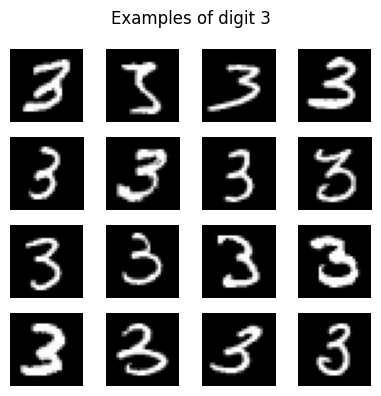

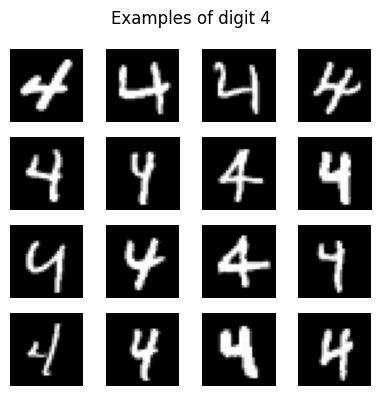

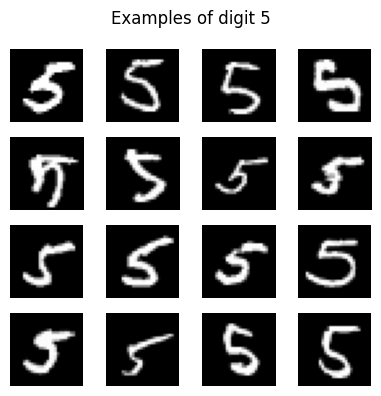

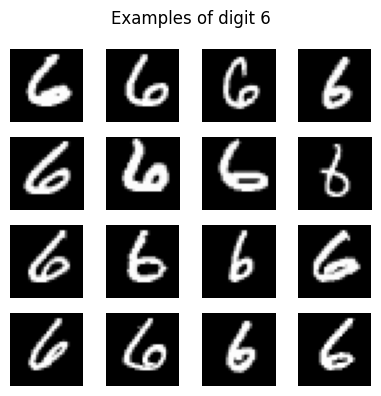

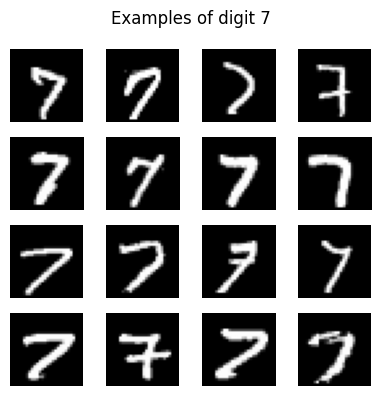

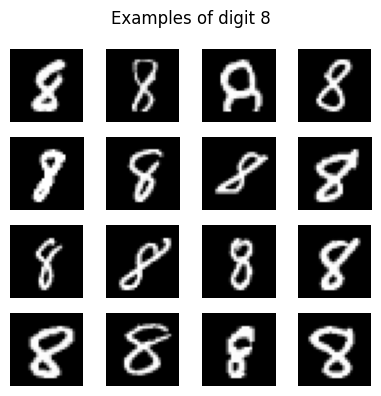

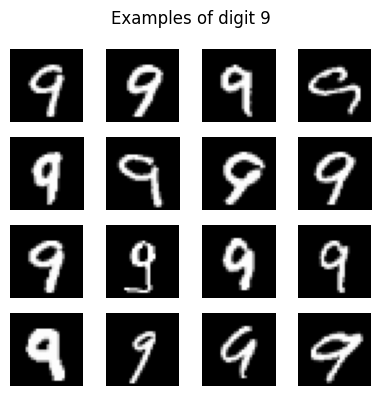

In [57]:
for i in range(10):
    plot_image(X_train, y_train, i)



 Modell 1 – Logistic Regression

Initialt testades hyperparametern C med värdena 0.1, 1 och 10, vilket gav cirka 85 % accuracy. Efter justering av parameterintervallet till 1, 3, 10 och 30 förbättrades resultatet till cirka 92 % accuracy.

Detta visar att modellen är känslig för regulariseringsparametern C och att en mer flexibel modell gav bättre generalisering.

In [58]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    "model__C": [0.1, 1.0, 3.0, 10.0 , 30.0 ],
    "model__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Best Params:", grid_lr.best_params_)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Best Params: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Logistic Regression Accuracy: 0.9212380952380952


Modell 2 – Random Forest

In [59]:

pipeline_rf = Pipeline([
    ("model", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Best Params:", grid_rf.best_params_)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Random Forest Accuracy: 0.9667619047619047


Modell 3 – ExtraTrees

In [60]:
pipeline_et = Pipeline([
    ("model", ExtraTreesClassifier(random_state=42))
])

param_grid_et = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 20]
}

grid_et = GridSearchCV(
    pipeline_et,
    param_grid=param_grid_et,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_et.fit(X_train, y_train)

best_et = grid_et.best_estimator_
accuracy_et = accuracy_score(y_test, best_et.predict(X_test))

print("ExtraTrees Best Params:", grid_et.best_params_)
print("ExtraTrees Accuracy:", accuracy_et)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
ExtraTrees Best Params: {'model__max_depth': None, 'model__n_estimators': 300}
ExtraTrees Accuracy: 0.9693333333333334


Validera och välj bästa modell

In [61]:

val_acc_lr = accuracy_score(y_val, best_lr.predict(X_val))
val_acc_rf = accuracy_score(y_val, best_rf.predict(X_val))
val_acc_et = accuracy_score(y_val, best_et.predict(X_val))

print("\nValidation accuracy:")
print("Logistic Regression:", val_acc_lr)
print("Random Forest:", val_acc_rf)
print("Extra Trees:", val_acc_et)

# Välj bästa modellen baserat på validation

models = {
    "Logistic Regression": val_acc_lr,
    "Random Forest": val_acc_rf,
    "Extra Trees": val_acc_et
}

best_name = max(models, key=models.get)

best_model = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "Extra Trees": best_et
}[best_name]

print("Chosen model:", best_name)



Validation accuracy:
Logistic Regression: 0.9205865549419159
Random Forest: 0.9708626928204152
Extra Trees: 0.9745762711864406
Chosen model: Extra Trees


 Slutlig testutvärdering

In [62]:
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print("\nTest accuracy:", test_acc)
print("\nClassification report:\n")
print(classification_report(y_test, test_pred))



Test accuracy: 0.9693333333333334

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1035
           1       0.99      0.99      0.99      1182
           2       0.97      0.97      0.97      1048
           3       0.96      0.96      0.96      1071
           4       0.98      0.97      0.97      1024
           5       0.98      0.96      0.97       947
           6       0.97      0.99      0.98      1031
           7       0.97      0.97      0.97      1094
           8       0.96      0.96      0.96      1024
           9       0.94      0.95      0.94      1044

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



Confusion Matrix

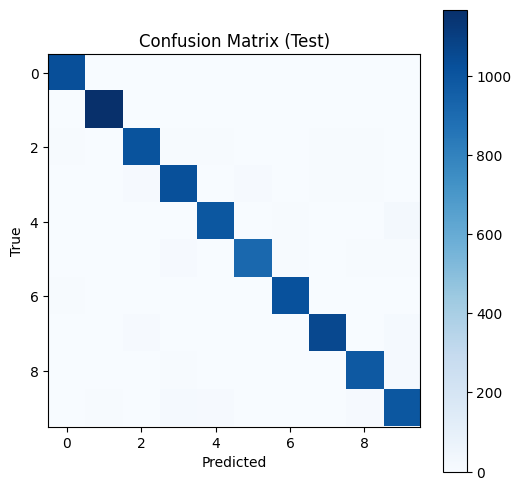

In [63]:
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

Träna om på train+val och spara modell

In [64]:
best_model.fit(X_trainval, y_trainval)

Path("models").mkdir(exist_ok=True)
joblib.dump(best_model, "models/mnist_pipeline.joblib")

print("Saved model to models/mnist_pipeline.joblib")

Saved model to models/mnist_pipeline.joblib
